In [55]:
%load_ext autoreload
%autoreload 2

from networkx.algorithms import approximation
from clusterparser import ClusterParser
from small_world import generate_circuit_graph, avg_path_length, avg_clustering_icn, noise_cell_proportion, remove_ICN_experiment
from rents_rule import RentsRuleCalculator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1 Clustering

In [29]:
node_file = "./test/adaptec1/adaptec1.nodes"
net_file = "./test/adaptec1/adaptec1.nets"

cp = ClusterParser(node_file, net_file, 100)
print(cp.num_std_cells, cp.num_macros, cp.num_terminals)

210904 63 480


In [30]:
prefix = "./test/adaptec1/placement-positions/adaptec1.gp.pl-"

# iteration range for clustering
its = list(range(150, 601, 50))
position_files = [f"{prefix}{i}" for i in its]
cp.load_positions(position_files)

Num cluster: 223, Num cells: 211447, Num intercells: 6993, ICN%: 3.31%


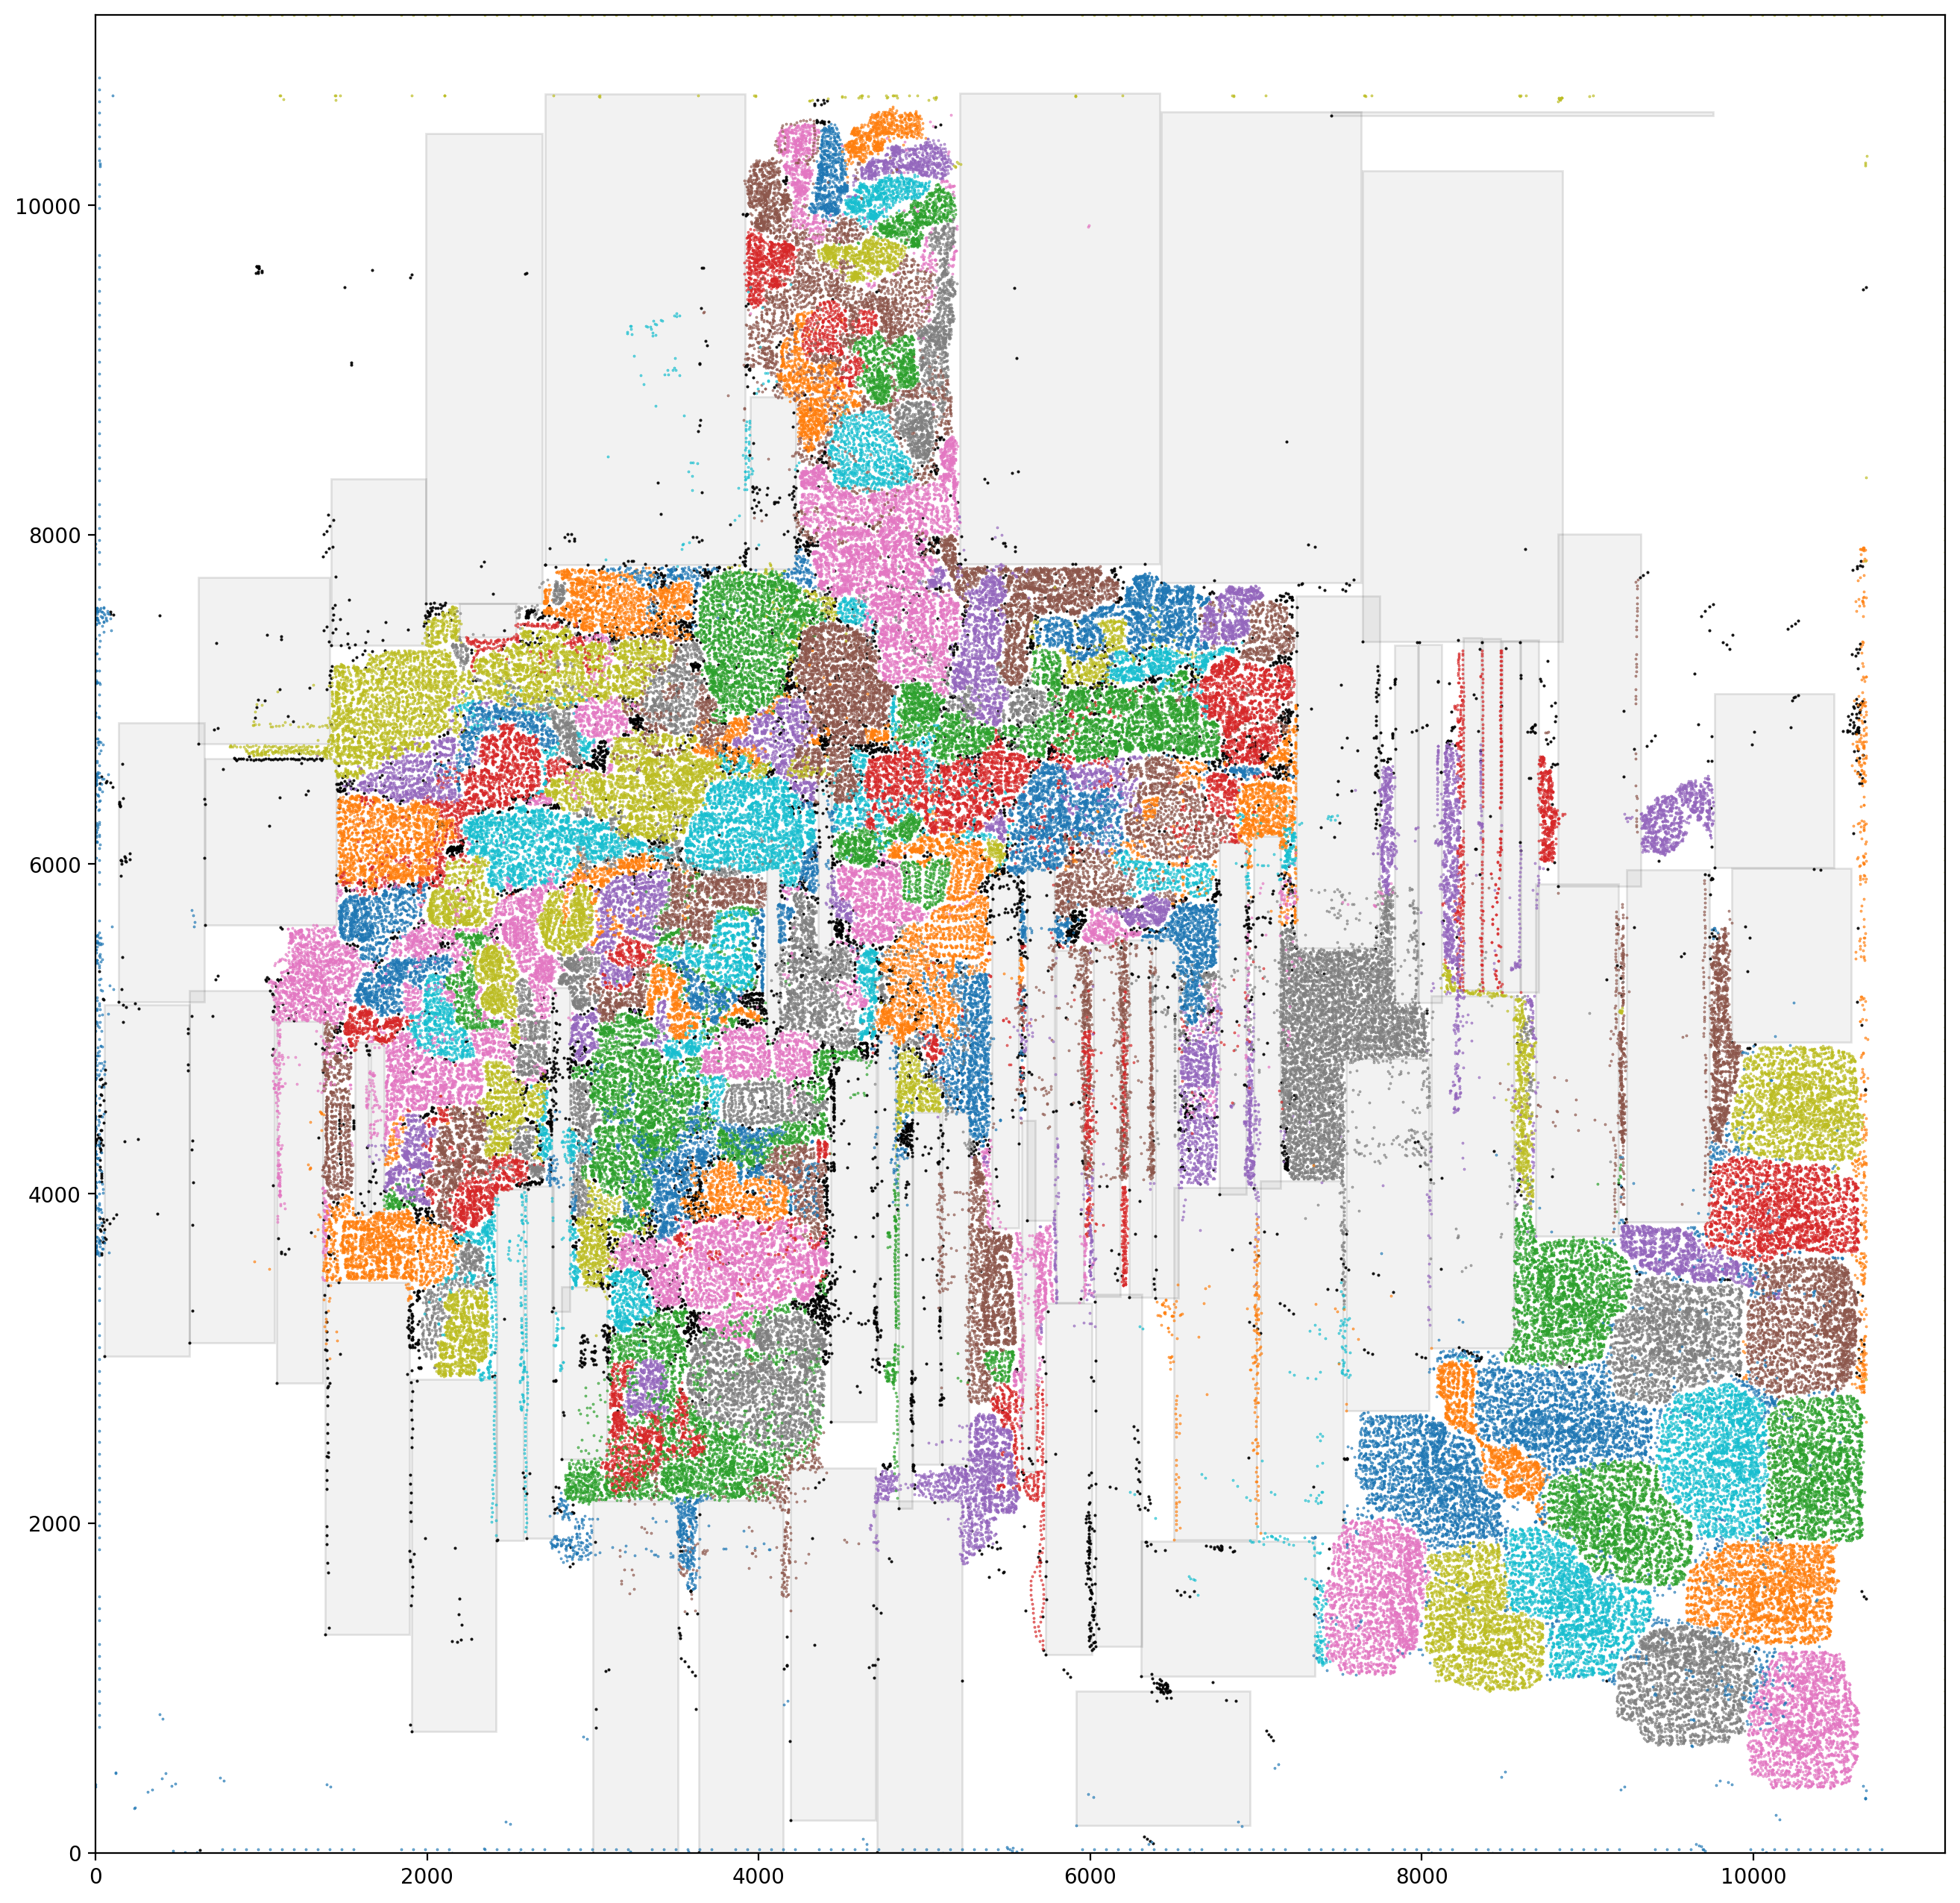

In [34]:
require_clustering = False
plot = True
cluster_file = "./test/adaptec1/adaptec1.cluster.csv"
output_file = "./test/adaptec1/adaptec1.cluster.txt"

msl = [400, 200, 100]
if require_clustering:
    cp.clustering(min_size_list=msl, min_samples=1, epsilon=0)
    cp.save_clustering(cluster_file, output_file)
else:
    cp.load_clustering(cluster_file)

print(f"Num cluster: {len(cp.unique_labels)}, Num cells: {len(cp.labels)}, Num intercells: {len(cp.noise_points)}, ICN%: {len(cp.noise_points)/len(cp.labels) * 100:.2f}%")
if plot:
    cp.plot_snapshot()

### 2 Rent's Rule Analysis

In [57]:
rrc = RentsRuleCalculator(cp)

Approximated Rent's exponent (block p): 0.66
Approximated Rent's coefficient (block dk): 6.55
Approximated Rent's exponent (cluster p): 0.27
Approximated Rent's coefficient (cluster k): 48.20
Approximated Rent's exponent (p): 0.85
Approximated Rent's coefficient (k): 6.66


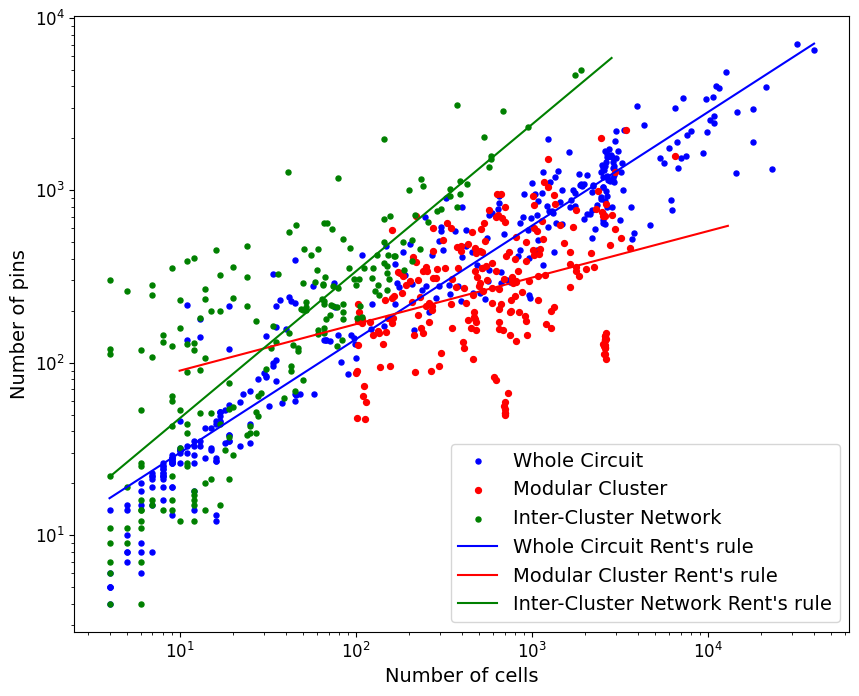

In [58]:
rrc.approximate()

### 3 Small World Analysis

In [36]:
G = generate_circuit_graph(cp)

In [53]:
N = 5000
M = 1000000

n_nodes = len(G.nodes)
n_edges = len(G.edges)

L_actual = avg_path_length(G, N, cp.labels)
L_icn = avg_path_length(G, N, cp.labels, mode="icn")
L_cluster = avg_path_length(G, N, cp.labels, mode="cluster")

C_actural = approximation.average_clustering(G, trials=M, seed=42)
C_icn = avg_clustering_icn(G, M, cp.labels, True)
C_cluster = avg_clustering_icn(G, M, cp.labels, False)

print(f"#nodes: {n_nodes:,}, #edges: {n_edges:,}")
print(f"L_netlist: {L_actual}, L_cluster: {L_cluster}, L_ICN: {L_icn}")
print(f"C_netlist: {C_actural:.4f}, C_cluster: {C_cluster:.4f}, C_ICN: {C_icn:.4f}")

#nodes: 211,447, #edges: 651,174
L_netlist: (7.2814, 0), L_cluster: (7.2804, 0), L_ICN: (7.4242, 0)
C_netlist: 0.0621, C_cluster: 0.0621, C_ICN: 0.0662


In [46]:
noise_prop = noise_cell_proportion(G, N, cp.labels)
print(f"Noise cell% on shortest path: {noise_prop[0] * 100:.2f}%")

Noise cell% on shortest path: 9.58%


In [50]:
remove_ICN_experiment(G, N, cp.labels)

L_remove_icn: 8.38, fail: 7/5000
L_remove_contrast: 7.36, fail: 1/5000
